# Assignment 1.3: Naive word2vec (40 points)

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch and code from your previous task.

## Results of this task: (30 points)
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)

## Extra questions: (10 points)
 * Intrinsic evaluation: you can find datasets [here](http://download.tensorflow.org/data/questions-words.txt)
 * Extrinsic evaluation: you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

# Implementation
## Use Google Colab with GPU to reproduce result

## Tsnecuda lib use GPU and work really fast but need some steps to install

In [1]:
# download and unpack tsnecuda from anaconda.org

!wget https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
!tar xvjf tsnecuda-2.1.0-cuda100.tar.bz2
!cp -r site-packages/* /usr/local/lib/python3.6/dist-packages/

# create a symbolic link between the downloaded libfaiss.so file and the location python's looking at

!echo $LD_LIBRARY_PATH
# this is probably /usr/lib64-nvidia

!ln -s /content/lib/libfaiss.so $LD_LIBRARY_PATH/libfaiss.so


--2020-02-24 13:51:43--  https://anaconda.org/CannyLab/tsnecuda/2.1.0/download/linux-64/tsnecuda-2.1.0-cuda100.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.92.24, 104.17.93.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.92.24|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5d019c23c7424a015486440c/5d790a95778a870c42137059?response-content-disposition=attachment%3B%20filename%3D%22tsnecuda-2.1.0-cuda100.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27tsnecuda-2.1.0-cuda100.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20200224T135143Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEKv%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJGMEQCIAmTCsTktrBFqtrQCd%2BVHNM9fgXOV0eF7is60ZFXC7llAiBNabmqfJJgjkiPn1fhHMxVQhIGVovqSLN15nohxs4UKiq0Awh0EAAaDDQ1NTg2NDA5ODM3OCIM0QzEoctdEf5h33Q%2FKpEDwoqtAX3HyY8EXDa

## Upload text8.zip please before run next cell

In [2]:
!rm ./text8
!unzip ./text8.zip

rm: cannot remove './text8': No such file or directory
Archive:  ./text8.zip
  inflating: text8                   


In [4]:
!pip install annoy

     |████████████████████████████████| 645kB 2.8MB/s 
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297345 sha256=8ae5109203d36854e90a4fa05a6f1bd50325a87fc90420607d1c59420578b7d5
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


## All imports here

In [0]:
import torch
from torch import nn
import torch.optim as optim

from collections import Counter
import numpy as np

import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from tsnecuda import TSNE
from sklearn import preprocessing

from annoy import AnnoyIndex

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Batcher for Skip-Gram or CBOW from previous assigment
- torch.tensor instead of np.array used

In [0]:
class Batcher():
    def __init__(self, text, limit=5, window_size=2, mode='sg'):
        """
        Batcher for Skip-Gram or CBOW

        :param text: String without newline symbols
        :param limit: Don't put words with less amount into the dictonary
        :param window_size: Window size ^)
        :param mode: cbow or sg
        """

        self.limit = limit
        self.window_size = window_size
        self.mode = mode

        self.text = text

        self.UNK = 'UNK'

        self.tokens = []
        self.tokens_ind = []


        self.vocabulary = set()
        self.word2index = dict()
        self.index2word = []

        self.most_common = []

        self._preprocess()

    @classmethod
    def from_file(cls, path, limit=5, window_size=2, mode='sg'):
        """
        Init Batcher from file

        :param path: Path to text file
        :param limit: Don't put words with less amount into the dictonary
        :param window_size: Window size ^)
        :param mode: cbow or sg
        :return: Batcher object
        """
        n = -1
        with open(path) as f:
            text = f.read(n)

        return cls(text, limit, window_size, mode)

    def _clean(self):
        # Everething expect [a-z ] already killed in our dataset
        pass

    def _tokenize(self):
        # Stupid tokenizer for our dataset
        self.tokens = self.text.split()

    def _build_vocabulary(self):
        counter_words = Counter(self.tokens)
        self.vocabulary = {word for word, counts in counter_words.items() if counts >= self.limit}
        most_common = counter_words.most_common(200)
        self.most_common = list(zip(*most_common))[0]

    def _numericalize(self):
        self.index2word = [self.UNK] + list(self.vocabulary)
        self.vocabulary.add(self.UNK)
        self.word2index = dict(zip(self.index2word, range(len(self.index2word))))
        self.tokens_ind = [self.word2index.get(word, 0) for word in self.tokens]

    def _preprocess(self):
        self._clean()
        self._tokenize()
        self._build_vocabulary()
        self._numericalize()

    def indices2words(self, indices):
        shape = indices.shape
        result = np.array([self.index2word[idx] for idx in indices.flatten()])
        return result.reshape(shape)

    def batch_generator(self, batch_size=5):
        """
        Batch generator

        :param batch_size: Elements in batch
        :return: Next batch
        """

        # Dataset is big enought
        # Let's skip last nonfull batch if exist
        count_batches = (len(self.tokens) - 2 * self.window_size) // batch_size
        print(f'count batches: {count_batches}')

        for batch_id in range(count_batches):
            batch_x = []
            batch_label = []
            for step_id in range(batch_size):
                pos_word_central = step_id + self.window_size + batch_id * batch_size
                x = self.tokens_ind[pos_word_central]
                batch_x.append(x)
                label_left = self.tokens_ind[pos_word_central - self.window_size : pos_word_central]
                label_right = self.tokens_ind[pos_word_central + 1 : pos_word_central + 1 + self.window_size]
                label = label_left + label_right
                batch_label.append(label)

            batch_x = torch.tensor(batch_x)
            batch_label = torch.tensor(batch_label)
            if self.mode == 'cbow':
                batch_x, batch_label = batch_label, batch_x
            yield batch_x, batch_label

## Settings for batcher

In [0]:
window_size = 3
batch_size = 2048
limit4dictonary = 10
mode='cbow'

## Batcher initialization

In [0]:
batcher = Batcher.from_file(path='./text8', limit=limit4dictonary, window_size=window_size, mode=mode)
batch_generator = batcher.batch_generator(batch_size)

## NN to train CBOW word2wec

In [0]:
class CBOW(nn.Module):
    def __init__(self, size_vocab, size_emb):
        super().__init__()

        self.emb = nn.Embedding(size_vocab, size_emb)
        self.out = nn.Linear(size_emb, size_vocab, bias=False)

    def forward(self, x):
        x = self.emb(x)
        out = self.out(x)
        return out

## Model and training settings

In [70]:
size_vocab = len(batcher.vocabulary)
size_emb = 300
learning_rate = 0.002
epochs = 3
print_every = 300

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cuda


In [0]:
model = CBOW(size_vocab=size_vocab, size_emb=size_emb)
model = model.to(device=device)

optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
fnc_loss = nn.CrossEntropyLoss(reduction='mean')

## Training word vectors
- No early stopping used
- No learning rate decreasing used

In [72]:
#Some magic to mention somewhere, how long it took to train

%%time

batches2plot = []
losses2plot = []
j = 0
try:
    for epoch in range(epochs):
        i = 0
        loss2print = 0
        for batch_idx, (batch_x, batch_labels) in enumerate(batcher.batch_generator(batch_size)):
            batch_x = batch_x.to(device=device, dtype=torch.long)
            batch_labels = batch_labels.to(device=device, dtype=torch.long)

            optimizer.zero_grad()

            labels_pred = model(batch_x)

            # print('batch_x: ', batch_x.size())
            # print('batch_labels: ', batch_labels.size())
            # print('labels_pred: ', labels_pred.size())

            batch_labels = batch_labels.reshape(-1, 1).expand(-1, batch_x.size()[1]).flatten()
            labels_pred = labels_pred.reshape(-1, labels_pred.shape[-1])

            # print('batch_labels_resized: ', batch_labels.size())
            # print('labels_pred_resized: ', labels_pred.size())

            loss = fnc_loss(labels_pred, batch_labels)

            loss.backward()
            optimizer.step()
            loss2print += float(loss)
            i+=1

            if batch_idx % print_every == 0:
                loss2print = loss2print / i
                batches2plot.append(j * print_every)
                j += 1
                losses2plot.append(loss2print)

                print(f'Epoch: {epoch} Iteration: {batch_idx}, loss = {loss2print}')
                i = 0
                loss2print = 0
except KeyboardInterrupt:
    print('Training Stopped')

count batches: 8303
Epoch: 0 Iteration: 0, loss = 10.928375244140625
Epoch: 0 Iteration: 300, loss = 8.422589020729065
Epoch: 0 Iteration: 600, loss = 7.30130033493042
Epoch: 0 Iteration: 900, loss = 7.252218607266744
Epoch: 0 Iteration: 1200, loss = 7.226859164237976
Epoch: 0 Iteration: 1500, loss = 7.212364433606465
Epoch: 0 Iteration: 1800, loss = 7.174331450462342
Epoch: 0 Iteration: 2100, loss = 7.121305004755656
Epoch: 0 Iteration: 2400, loss = 7.193268283208211
Epoch: 0 Iteration: 2700, loss = 7.245403860410055
Epoch: 0 Iteration: 3000, loss = 7.193033757209778
Epoch: 0 Iteration: 3300, loss = 7.115913950602214
Epoch: 0 Iteration: 3600, loss = 7.117172392209371
Epoch: 0 Iteration: 3900, loss = 7.103361264864604
Epoch: 0 Iteration: 4200, loss = 7.090761171976725
Epoch: 0 Iteration: 4500, loss = 7.097284302711487
Epoch: 0 Iteration: 4800, loss = 7.033837421735128
Epoch: 0 Iteration: 5100, loss = 7.1244645563761395
Epoch: 0 Iteration: 5400, loss = 7.027874862353007
Epoch: 0 Iterati

## It took 80 minutes to train on GPU and I know how to speed up this process

# Plotted Loss

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Batch')]

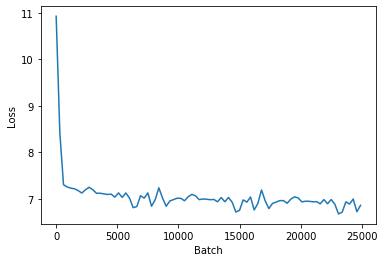

In [73]:
sns.lineplot(batches2plot, losses2plot).set(xlabel='Batch', ylabel='Loss')

# Trained word vectors
- w2 will be used for next subtasks

In [0]:
w1 = model.emb.weight.detach().cpu().numpy()
w2 = model.out.weight.detach().cpu().numpy()
w = (w1 + w2) / 2

In [0]:
np.save('w2w', w2)

# beautiful visualizations (T-SNE)

In [0]:
output_notebook()
def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [0]:
tsne = TSNE(n_components = 2)
word_tsne = tsne.fit_transform(w2)

scaler = preprocessing.StandardScaler()
word_tsne = scaler.fit_transform(word_tsne)


In [78]:
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=batcher.index2word)

Figure(id='1225', ...)

# Function to map token to corresponding word vector
- word2vector(word)

In [0]:
def index2vector(word_index):
    return w2[word_index]

def word2vector(word):
    return w2[batcher.word2index[word]]

# Extra questions
## Quantitative Evalution

In [0]:
# def cosine_similarity(word1, word2, word2vec):
#   vec1 = word2vec(word1)
#   vec2 = word2vec(word2)
#   return np.dot(vec1, vec2) / np.linalg.norm(vec1) / np.linalg.norm(vec2)
class EmbeddingsExplorer():
    def __init__(self, token_to_idx, vectors, metric='euclidean'):
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx
                             in self.token_to_idx.items()}
        self.vectors = vectors
        self.metric = metric

        self.index = AnnoyIndex(vectors.shape[1], metric=metric)

        print('Building index is started')
        for i in self.token_to_idx.values():
            self.index.add_item(i, self.vectors[i])

        self.index.build(50)
        print('Building index is finished')

    def get_embedding(self, token):
        return self.vectors[self.token_to_idx[token]]

    def get_closest_to_vector(self, vector, n=1):
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.idx_to_token[neighbor] for neighbor in nn_indices]

    def compute_closest_tokens(self, target_token, n=1):
        vector = self.get_embedding(target_token)
        closest_tokens = self.get_closest_to_vector(vector, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token != target_token]
        print(f'{target_token}: {closest_tokens}')

    def compute_analogy(self, token1, token2, token3, n=30):
        vec1 = self.get_embedding(token1)
        vec2 = self.get_embedding(token2)
        vec3 = self.get_embedding(token3)
        vec4 = vec3 + vec2 - vec1

        tokens = set([token1, token2, token3])
        closest_tokens = self.get_closest_to_vector(vec4, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token not in tokens]

        if len(closest_tokens) == 0:
            print('Could not find nearest neighbors for the computed vector')
            return

        print(f'{token1}:{token2} :: {token3}:{closest_tokens}')

In [81]:
explorer = EmbeddingsExplorer(batcher.word2index, w2)

Building index is started
Building index is finished


## Analogies

In [ ]:
explorer.compute_analogy('dance', 'dancing', 'discover')

In [ ]:
explorer.compute_analogy('king', 'man', 'queen')

In [ ]:
explorer.compute_analogy('moscow', 'russia', 'london')

## Top closest words

In [ ]:
explorer.compute_closest_tokens('one', n=10)


In [ ]:
explorer.compute_closest_tokens('computer', n=10)


In [ ]:
explorer.compute_closest_tokens('game', n=10)


- Not so bad as can be with closest words
- Analogies don't impress

- Unfortunally I did't have a time to tune this word2vec and task did't have any requriments to quality

- In other hand I'l be back to this task when I'll have a free time

In [95]:
- Not so bad as can be with closest words
- Analogies don't impress

- Unfortunally I did't have a time to tune this word2vec and task did't have any requriments to quality

- In other hand I'l be back to this task when I'll have a free time

dance:dancing :: discover:['warn', 'instructed', 'invoke', 'hera', 'odin', 'posed', 'hebrews', 'anybody', 'confront', 'compelled', 'voyages', 'hades', 'reluctantly', 'submit', 'jealous', 'adversary', 'crush', 'wounds', 'jinn', 'barbarians', 'implicitly', 'absurd', 'whereupon', 'replies', 'strangers', 'guardians', 'richer', 'unwilling', 'lure', 'endure']


In [91]:
explorer.compute_analogy('king', 'man', 'queen')

king:man :: queen:['woman', 'dead', 'boy', 'love', 'dog', 'heart', 'mother', 'horse', 'club', 'cover', 'child', 'green', 'car', 'blue', 'ball', 'brown', 'big', 'face', 'master', 'voice', 'night', 'artist', 'gold', 'stage', 'lady', 'daughter', 'female', 'shot', 'plays']


In [88]:
explorer.compute_analogy('moscow', 'russia', 'london')

moscow:russia :: london:['england', 'france', 'british', 'germany', 'great', 'french', 'part', 'south', 'english', 'europe', 'country', 'house', 'king', 'west', 'european', 'german', 'ii', 'land', 'john', 'north', 'second', 'general', 'area', 'became', 'day', 'city', 'america', 'power', 'old', 'history']


## Top closest words

In [85]:
explorer.compute_closest_tokens('one', n=10)


one: ['two', 'zero', 'nine', 'three', 'in', 'five', 's', 'eight', 'four']


In [86]:
explorer.compute_closest_tokens('computer', n=10)


computer: ['design', 'software', 'technology', 'using', 'information', 'systems', 'development', 'program', 'machine']


In [87]:
explorer.compute_closest_tokens('game', n=10)


game: ['games', 'series', 'show', 'second', 'original', 'line', 'home', 'following', 'another']


- Not so bad as can be with closest words
- Analogies don't impress

- Unfortunally I did't have a time to tune this word2vec and task did't have any requriments to quality

- In other hand I'l be back to this task when I'll have a free time